In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import subprocess
import getpass
import sqlite3
import time
import seaborn as sb
import psycopg2
from scipy.interpolate import UnivariateSpline
import json
%matplotlib inline
from IPython.core.display import HTML
pd.options.display.max_columns = 500
#import seaborn as sb
import datetime
from sqlalchemy import create_engine
from difflib import SequenceMatcher, get_close_matches
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

## Read in data and meta data

In [2]:
# Metadata
metadata = pd.read_excel('metadata.xlsx')
column_mapping = {}
for i, row in metadata.iterrows():
    column_mapping[row['NAME']] = row['LABEL']

In [463]:
# Inwoners
for i, year in enumerate(np.arange(start=2010, stop=2016)):
    inwoners_year = pd.read_excel('inwoners.xls', skiprows=2, sheetname='Loop van de bevolking in {}'.format(year))
    inwoners_year = inwoners_year.iloc[:,0:3]
    inwoners_year.columns=['niscode', 'gemeente', 'inwoners']
    inwoners_year['year'] = year
    if(i==0): aantal_inwoners = inwoners_year
    else: aantal_inwoners = pd.concat([aantal_inwoners, inwoners_year], axis=0)

# Hier zitten doubles in?
aantal_inwoners = aantal_inwoners.drop_duplicates()

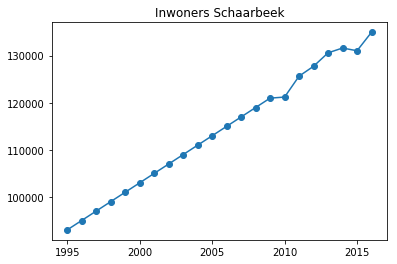

In [465]:
from scipy import stats
# Fill in the missing years with a linear regression
for i, gemeente in enumerate(np.unique(aantal_inwoners['gemeente'])):
    subset = aantal_inwoners.loc[aantal_inwoners['gemeente']==gemeente, :]
    # Create linear regression object
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['year'], subset['inwoners'])
    # Predict the other years
    to_predict = pd.DataFrame.from_dict({'year':list(np.arange(1995, 2010))+[2016], 
                        'inwoners':np.repeat(0, len(np.arange(1995, 2010))+1)})
    to_predict['gemeente'] = gemeente
    to_predict['niscode'] = subset['niscode'].values[0]
    to_predict['inwoners'] = np.round(intercept + slope * to_predict['year'])
    # Add the predictions to aantal inwoners
    aantal_inwoners = pd.concat([aantal_inwoners, to_predict], axis=0)

aantal_inwoners = aantal_inwoners.sort_values(['gemeente', 'year'])
plt.plot(aantal_inwoners.loc[aantal_inwoners['gemeente']=='Schaarbeek', 'year'],
         aantal_inwoners.loc[aantal_inwoners['gemeente']=='Schaarbeek', 'inwoners'], 'o-')
plt.title('Inwoners Schaarbeek')

In [6]:
for i, filename in enumerate(os.listdir('accidents')):
    print('Reading file {}'.format(filename))
    data_year = pd.read_excel('accidents/{}'.format(filename))

    #data_year = data_year[['DT_DAY', 'MS_VCT', 'MS_SLY_INJ', 'MS_SERLY_INJ', 'MS_MORY_INJ', 'MS_DEAD', 'MS_DEAD_30_DAYS', 'TX_VCT_TYPE_DESCR_NL',
    #       'TX_ROAD_USR_TYPE_DESCR_NL', 'TX_ROAD_TYPE_DESCR_NL', 'TX_LIGHT_COND_DESCR_NL', 'TX_COLL_TYPE_DESCR_NL', 'TX_BUILD_UP_AREA_DESCR_NL',
    #      'TX_AGE_CLS_DESCR_NL', 'TX_MUNTY_DESCR_NL', 'TX_SEX_DESCR_NL']]
    #data_year.columns = data_year.columns.map(lambda x: column_mapping[x])
    #data_year['Day'] = pd.to_datetime(data_year['Day'])

    if(i==0): accidents = data_year
    else: accidents = pd.concat([accidents, data_year], axis=0)
    

Reading file data_1995.xlsx
Reading file data_1996.xlsx
Reading file data_1997.xlsx
Reading file data_1998.xlsx
Reading file data_1999.xlsx
Reading file data_2000.xlsx
Reading file data_2001.xlsx
Reading file data_2002.xlsx
Reading file data_2005.xlsx
Reading file data_2006.xlsx
Reading file data_2007.xlsx
Reading file data_2008.xlsx
Reading file data_2009.xlsx
Reading file data_2010.xlsx
Reading file data_2011.xlsx
Reading file data_2012.xlsx
Reading file data_2013.xlsx
Reading file data_2014.xlsx
Reading file data_2015.xlsx
Reading file data_2016.xlsx


In [562]:
accidents['TX_RGN_DESCR_NL'].value_counts()

Vlaams Gewest                     1143322
Waals Gewest                       496521
Brussels Hoofdstedelijk Gewest     120669
Name: TX_RGN_DESCR_NL, dtype: int64

In [565]:
brusselse_gemeenten = list(np.unique(accidents.loc[accidents['TX_RGN_DESCR_NL']=='Brussels Hoofdstedelijk Gewest','TX_MUNTY_DESCR_NL']))

## Clean up some issues

In [367]:
accidents_cleaned = accidents.copy()

In [368]:
# There is an issue with some years, there are columns that other years dont have
columns_not_in_meta_data = [column for column in accidents_cleaned.columns if column not in column_mapping.keys()]
print('Columns not in the meta data: {}'.format(', '.join(columns_not_in_meta_data)))
print('Years that have this problem: {}'.format(list(np.unique(accidents_cleaned.loc[~accidents_cleaned['MS_ACCT'].isnull(),'DT_DAY'].map(lambda x: x.year)))))
# Delete year 1997
accidents_cleaned['year'] = accidents_cleaned['DT_DAY'].map(lambda x: x.year)
accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['year']!= 2017]
accidents_cleaned = accidents_cleaned.drop(columns_not_in_meta_data, axis=1)

Columns not in the meta data: MS_ACCT, MS_ACCT_WITH_DEAD, MS_ACCT_WITH_DEAD_30_DAYS, MS_ACCT_WITH_MORY_INJ, MS_ACCT_WITH_SERLY_INJ, MS_ACCT_WITH_SLY_INJ
Years that have this problem: [1997]


In [369]:
# Only keep relevant columns, and give them the names from the meta data
accidents_cleaned = accidents_cleaned[['DT_DAY', 'MS_VCT', 'MS_SLY_INJ', 'MS_SERLY_INJ', 'MS_MORY_INJ', 'MS_DEAD', 'MS_DEAD_30_DAYS', 'TX_VCT_TYPE_DESCR_NL',
           'TX_ROAD_USR_TYPE_DESCR_NL', 'TX_ROAD_TYPE_DESCR_NL', 'TX_LIGHT_COND_DESCR_NL', 'TX_COLL_TYPE_DESCR_NL', 'TX_BUILD_UP_AREA_DESCR_NL',
          'TX_AGE_CLS_DESCR_NL', 'TX_MUNTY_DESCR_NL', 'TX_SEX_DESCR_NL', 'CD_MUNTY_REFNIS']]
accidents_cleaned.columns = accidents_cleaned.columns.map(lambda x: column_mapping[x])
accidents_cleaned.sample()

,Day,Number of victims,Number of slightly injured,Number of severely injured,Number of mortally injured,Number of dead,Number of dead 30 days,"Victime type (driver, passenger, other victime)",Road user type,Road type,Light conditions,Collision type,Build up area,Age class,Municipality name in Dutch,Sex,REFNIS code of the municipality
35032,1995-04-01,0.0,0.0,0.0,0.0,0.0,0.0,Bestuurder of voetganger,Personenauto,"Gewestweg, provincieweg of gemeenteweg",Bij klaarlichte dag,Kettingbotsing (4 bestuurders of meer),Binnen bebouwde kom,Niet beschikbaar,Schilde,Niet beschikbaar,11039


In [370]:
# Add year, month and month_year
accidents_cleaned['month'] = accidents_cleaned['Day'].map(lambda x: x.month)
accidents_cleaned['year'] = accidents_cleaned['Day'].map(lambda x: x.year)
accidents_cleaned['month_year'] = accidents_cleaned['Day'].dt.to_period('M')

## Accidents types

- Only work with accidents where a "voetganger" was the victim
- Drop the accidents on the highway

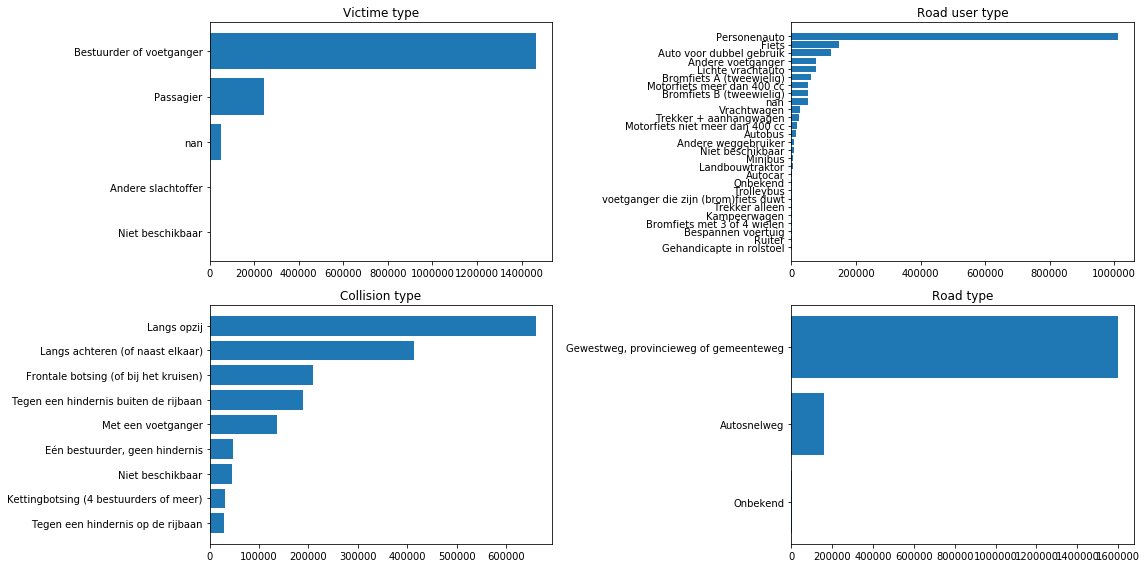

In [371]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

to_plot = accidents_cleaned['Victime type (driver, passenger, other victime)'].value_counts(dropna=False, ascending=True)
axes[0][0].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[0][0].set_title('Victime type')

to_plot = accidents_cleaned['Road user type'].value_counts(dropna=False, ascending=True)
axes[0][1].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[0][1].set_title('Road user type')

to_plot = accidents_cleaned['Collision type'].value_counts(dropna=False, ascending=True)
axes[1][0].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[1][0].set_title('Collision type')

to_plot = accidents_cleaned['Road type'].value_counts(dropna=False, ascending=True)
axes[1][1].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[1][1].set_title('Road type')

figure.tight_layout()

In [372]:
accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['Collision type']=='Met een voetganger',:]
accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['Road type'] != 'Autosnelweg',:]

## Give some kind of severity to accidents

In [373]:
severity_weights = {'Number of slightly injured':1,
                    'Number of severely injured': 10,
                   'Number of mortally injured': 20,
                   'Number of dead': 20,
                   'Number of dead 30 days': 20}

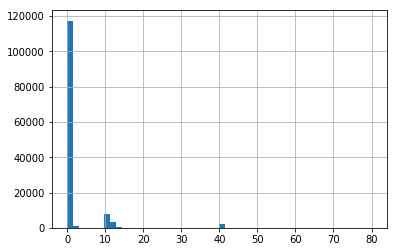

In [374]:
accidents_cleaned['total_severity'] = 0
for key, value in severity_weights.items():
    accidents_cleaned['total_severity'] += accidents_cleaned[key] * value
    
accidents_cleaned['total_severity'].hist(bins=50)

## Merge with number of inhabitants

In [376]:
accidents_cleaned = accidents_cleaned.rename(columns={'REFNIS code of the municipality': 'niscode'})
accidents_cleaned = pd.merge(accidents_cleaned, aantal_inwoners[['inwoners', 'niscode', 'year']], how='left', 
                             left_on=['niscode', 'year'],  right_on=['niscode', 'year'])

accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['inwoners'] != 0, :]

## Group by commune and year

In [493]:
accidents_per_commune = accidents_cleaned.groupby(['Municipality name in Dutch', 'year'])['total_severity'].agg(len)
accidents_per_commune = accidents_per_commune.reset_index()
niscodes = accidents_cleaned[['Municipality name in Dutch', 'niscode']].drop_duplicates()
accidents_per_commune = pd.merge(accidents_per_commune, niscodes, how='left')
accidents_per_commune.columns = ['gemeente', 'year', 'aantal_accidenten', 'niscode']
accidents_per_commune = pd.merge(accidents_per_commune, aantal_inwoners[['niscode', 'year', 'inwoners']], how='left', 
                                 left_on=['niscode', 'year'], right_on=['niscode', 'year'])
accidents_per_commune['accidents_per_inhabitant'] = accidents_per_commune['aantal_accidenten'] / accidents_per_commune['inwoners']
accidents_per_commune = accidents_per_commune.fillna(0)
accidents_per_commune['inwoners_log'] = np.log10(accidents_per_commune['inwoners']+1)
accidents_per_commune['aantal_accidenten_log'] = np.log10(accidents_per_commune['aantal_accidenten']+1)
accidents_per_commune.sample(5)

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant,inwoners_log,aantal_accidenten_log
1720,Dalhem,1995,18.0,62027,5632.0,0.003196,3.750740,1.278754
8239,Vresse-sur-Semois,2014,1.0,91143,2706.0,0.000370,3.432488,0.301030
1174,Bouillon,2011,12.0,84010,5464.0,0.002196,3.737590,1.113943
3951,Ingelmunster,2009,12.0,36007,10658.0,0.001126,4.027716,1.113943
2631,Florennes,2007,12.0,93022,10926.0,0.001098,4.038501,1.113943


In [495]:
#accidents_per_commune.loc[accidents_per_commune['gemeente']=='Balen',:]
#accidents_per_commune.loc[accidents_per_commune['gemeente']=='Balen',:]


## Is Schaarbeek worse per capita than other communes in 2016?

In [496]:
accidents_per_commune_2016 = accidents_per_commune.loc[accidents_per_commune['year']==2016,:].copy()
accidents_per_commune_2016['accidents_per_inhabitant'] = accidents_per_commune_2016['accidents_per_inhabitant']*1000

In [566]:
accidents_per_commune_2016['Brusselse_gemeente'] = accidents_per_commune_2016['gemeente'].isin(brusselse_gemeenten)

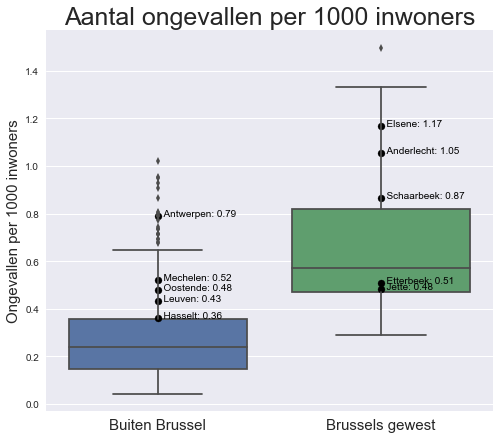

In [586]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
sb.boxplot(x="Brusselse_gemeente", y="accidents_per_inhabitant", data=accidents_per_commune_2016, ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(['Buiten Brussel', 'Brussels gewest'], size=15)
ax.set_ylabel('Ongevallen per 1000 inwoners', size=15)
ax.set_title('Aantal ongevallen per 1000 inwoners', size=25)

gemeentes = ['Jette', 'Anderlecht', 'Elsene', 'Etterbeek', 'Schaarbeek', 'Mechelen', 'Antwerpen', 'Hasselt', 'Leuven', 'Oostende']

to_plot = accidents_per_commune_2016.loc[accidents_per_commune_2016['gemeente'].isin(gemeentes),:]
to_plot.index = np.arange(len(to_plot))

for i, row in to_plot.iterrows():
    
    ax.scatter(y=row['accidents_per_inhabitant'], x=row['Brusselse_gemeente'], color='black', )
    ax.text(y=row['accidents_per_inhabitant'], x=row['Brusselse_gemeente'], color='black', size=10,
            s='  {}: {:.2f}'.format(row['gemeente'], row['accidents_per_inhabitant']))


#ax = sb.swarmplot(x="Brusselse_gemeente", y="accidents_per_inhabitant", data=accidents_per_commune_2016, color=".25")

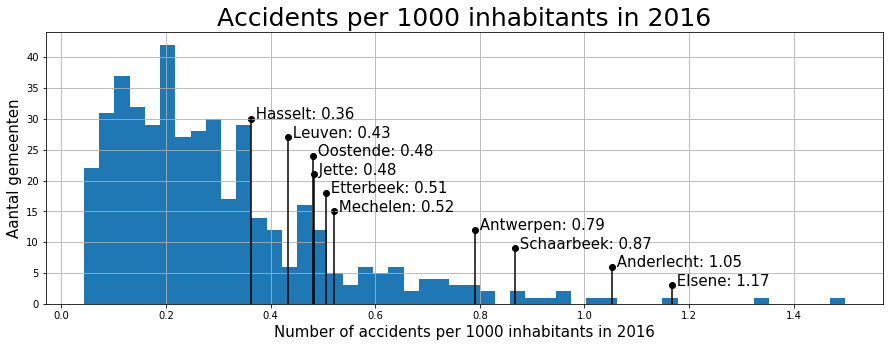

In [554]:
figure, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))
accidents_per_commune_2016['accidents_per_inhabitant'].hist(ax=ax,bins=50 )
ax.set_title('Accidents per 1000 inhabitants in 2016', size=25)
ax.set_xlabel('Number of accidents per 1000 inhabitants in 2016', size=15)
ax.set_ylabel('Aantal gemeenten', size=15)
gemeentes = ['Jette', 'Anderlecht', 'Elsene', 'Etterbeek', 'Schaarbeek', 'Mechelen', 'Antwerpen', 'Hasselt', 'Leuven', 'Oostende']
to_plot = accidents_per_commune_2016.loc[accidents_per_commune_2016['gemeente'].isin(gemeentes),['gemeente','accidents_per_inhabitant']]
to_plot = to_plot.sort_values('accidents_per_inhabitant')
to_plot.index = np.arange(len(to_plot))
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

for i, row in to_plot.iterrows():
    
    ax.scatter(row['accidents_per_inhabitant'], y=30 - 3*i, color='black', )
    ax.vlines(x=row['accidents_per_inhabitant'], ymin=0, ymax=30 - 3*i, color='black')
    ax.text(x=row['accidents_per_inhabitant'],  y=30 - 3*i, color='black', s=' {}: {:.2f}'.format(
        row['gemeente'], row['accidents_per_inhabitant']), size=15)

In [506]:
sum(accidents_per_commune_2016['aantal_accidenten']==1)

94

In [509]:
accidents_per_commune_2016.sort_values('accidents_per_inhabitant', ascending=True).head(10)

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant,inwoners_log,aantal_accidenten_log
8844,Zemst,2016,1.0,23096,22955.0,0.043563,4.360896,0.30103
571,Balen,2016,1.0,13003,22223.0,0.044998,4.346822,0.30103
3761,Hoogstraten,2016,1.0,13014,21370.0,0.046795,4.329825,0.30103
3484,Herent,2016,1.0,24038,21300.0,0.046948,4.328400,0.30103
7310,Sint-Katelijne-Waver,2016,1.0,12035,20510.0,0.048757,4.311987,0.30103
4699,Lebbeke,2016,1.0,42011,18899.0,0.052913,4.276462,0.30103
6686,Ranst,2016,1.0,11035,18792.0,0.053214,4.273996,0.30103
4181,Kasterlee,2016,1.0,13017,17958.0,0.055685,4.254282,0.30103
7631,Stekene,2016,1.0,46024,17828.0,0.056092,4.251127,0.30103
3625,Herzele,2016,1.0,41027,17547.0,0.056990,4.244228,0.30103


In [510]:
accidents_per_commune_2016.sort_values('accidents_per_inhabitant', ascending=True).tail(10)

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant,inwoners_log,aantal_accidenten_log
7064,Schaarbeek,2016,117.0,21015,134943.0,0.867033,5.130154,2.071882
5182,Luik,2016,179.0,62063,197404.0,0.906770,5.295358,2.255273
4273,Knokke-Heist,2016,31.0,31043,33422.0,0.927533,4.524045,1.505150
4425,Kortessem,2016,8.0,73040,8418.0,0.950344,3.925261,0.954243
2132,Drogenbos,2016,5.0,23098,5233.0,0.955475,3.718834,0.778151
1078,Boom,2016,18.0,11005,17651.0,1.019772,4.246794,1.278754
244,Anderlecht,2016,126.0,21001,119709.0,1.052552,5.078130,2.103804
2305,Elsene,2016,100.0,21009,85722.0,1.166562,4.933097,2.004321
7233,Sint-Gillis,2016,69.0,21013,51810.0,1.331789,4.714422,1.845098
1368,Brussel,2016,267.0,21004,178280.0,1.497644,5.251105,2.428135


In [394]:
#accidents_per_commune_2016.loc[accidents_per_commune_2016['gemeente']=='Schaarbeek','accidents_per_inhabitant']

16564    0.000867
Name: accidents_per_inhabitant, dtype: float64

In [307]:
#gemeentes = ['Tervuren', 'Vilvoorde', 'Leuven', 'Schaarbeek', 'Jette', 'Elsene', 'Sint-Jans-Molenbeek', 'Oudergem']

In [512]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
#for i, gemeente in enumerate(gemeentes):
#    subset = accidents_per_commune.loc[accidents_per_commune['gemeente']==gemeente,:]
#
#    plt.plot(subset['inwoners_log'], subset['aantal_accidenten'], '.', color=colors[i])
#    plt.xlabel('Inwoners')
#    plt.ylabel('Som van accidenten')

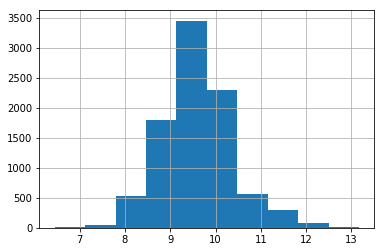

In [513]:
np.log(accidents_per_commune['inwoners']+1).hist()

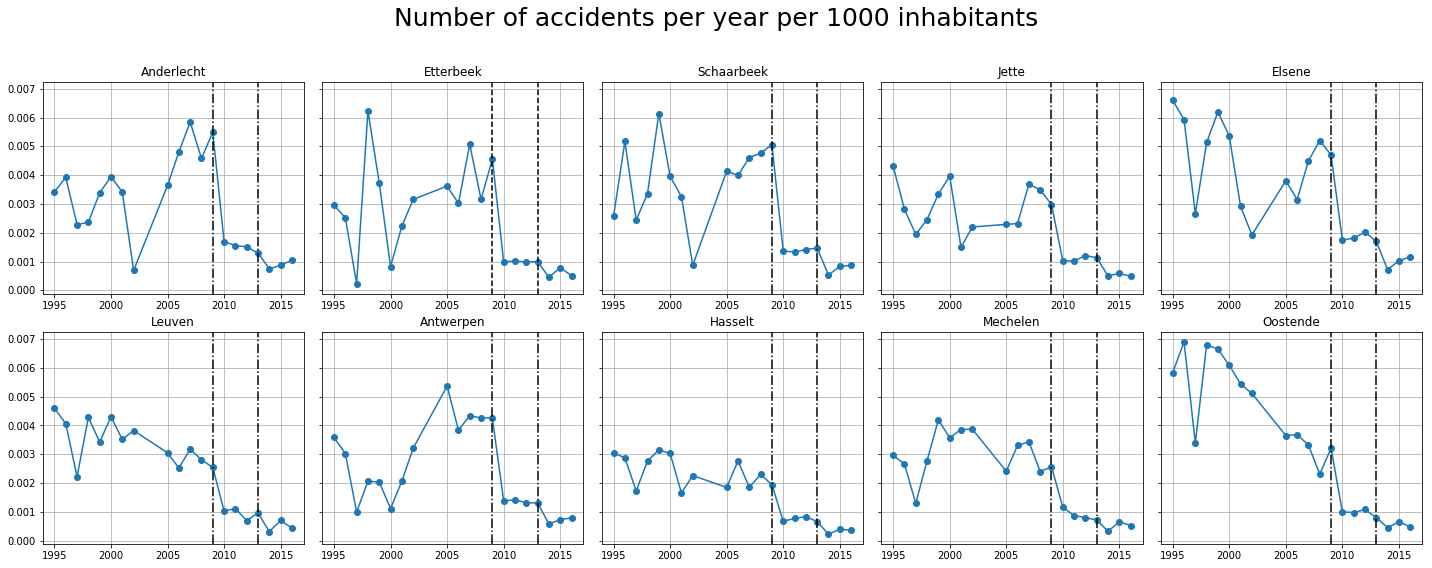

In [536]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey=True)

accidents_hasselt = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Anderlecht', :].sort_values('year')
axes[0][0].plot(accidents_hasselt['year'], accidents_hasselt['accidents_per_inhabitant'], '-o')
axes[0][0].set_title('Anderlecht')
axes[0][0].axvline(2009, linestyle='-.', color='black')
axes[0][0].axvline(2013, linestyle='-.', color='black')
axes[0][0].grid()

accidents_leuven = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Etterbeek', :].sort_values('year')
axes[0][1].plot(accidents_leuven['year'], accidents_leuven['accidents_per_inhabitant'], '-o')
axes[0][1].set_title('Etterbeek')
axes[0][1].axvline(2009, linestyle='--', color='black')
axes[0][1].axvline(2013, linestyle='--', color='black')
axes[0][1].grid()


accidents_schaarbeek = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Schaarbeek', :].sort_values('year')
axes[0][2].plot(accidents_schaarbeek['year'], accidents_schaarbeek['accidents_per_inhabitant'], '-o')
axes[0][2].set_title('Schaarbeek')
axes[0][2].axvline(2009, linestyle='-.', color='black')
axes[0][2].axvline(2013, linestyle='-.', color='black')
axes[0][2].grid()


accidents_jette = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Jette', :].sort_values('year')
axes[0][3].plot(accidents_jette['year'], accidents_jette['accidents_per_inhabitant'], '-o')
axes[0][3].set_title('Jette')
axes[0][3].axvline(2009, linestyle='-.', color='black')
axes[0][3].axvline(2013, linestyle='-.', color='black')
axes[0][3].grid()

accidents_tervuren = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Elsene', :].sort_values('year')
axes[0][4].plot(accidents_tervuren['year'], accidents_tervuren['accidents_per_inhabitant'], '-o')
axes[0][4].set_title('Elsene')
axes[0][4].axvline(2009, linestyle='-.', color='black')
axes[0][4].axvline(2013, linestyle='-.', color='black')
axes[0][4].grid()

accidents_hasselt = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Leuven', :].sort_values('year')
axes[1][0].plot(accidents_hasselt['year'], accidents_hasselt['accidents_per_inhabitant'], '-o')
axes[1][0].set_title('Leuven')
axes[1][0].axvline(2009, linestyle='-.', color='black')
axes[1][0].axvline(2013, linestyle='-.', color='black')
axes[1][0].grid()

accidents_leuven = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Antwerpen', :].sort_values('year')
axes[1][1].plot(accidents_leuven['year'], accidents_leuven['accidents_per_inhabitant'], '-o')
axes[1][1].set_title('Antwerpen')
axes[1][1].axvline(2009, linestyle='-.', color='black')
axes[1][1].axvline(2013, linestyle='-.', color='black')
axes[1][1].grid()


accidents_schaarbeek = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Hasselt', :].sort_values('year')
axes[1][2].plot(accidents_schaarbeek['year'], accidents_schaarbeek['accidents_per_inhabitant'], '-o')
axes[1][2].set_title('Hasselt')
axes[1][2].axvline(2009, linestyle='-.', color='black')
axes[1][2].axvline(2013, linestyle='-.', color='black')
axes[1][2].grid()


accidents_jette = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Mechelen', :].sort_values('year')
axes[1][3].plot(accidents_jette['year'], accidents_jette['accidents_per_inhabitant'], '-o')
axes[1][3].set_title('Mechelen')
axes[1][3].axvline(2009, linestyle='-.', color='black')
axes[1][3].axvline(2013, linestyle='-.', color='black')
axes[1][3].grid()

accidents_tervuren = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Oostende', :].sort_values('year')
axes[1][4].plot(accidents_tervuren['year'], accidents_tervuren['accidents_per_inhabitant'], '-o')
axes[1][4].set_title('Oostende')
axes[1][4].axvline(2009, linestyle='-.', color='black')
axes[1][4].axvline(2013, linestyle='-.', color='black')

axes[1][4].grid()

figure.suptitle('Number of accidents per year per 1000 inhabitants', size=25)
figure.tight_layout()
figure.subplots_adjust(top=0.85)

In [ ]:
# Per inhabitant
accidents_hasselt = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Hasselt', :].sort_values('year')
axes[1][0].plot(accidents_hasselt['year'], accidents_hasselt['accidents_per_inhabitant'], '-o')
axes[1][0].set_title('Hasselt')

accidents_leuven = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Leuven', :].sort_values('year')
axes[1][1].plot(accidents_leuven['year'], accidents_leuven['accidents_per_inhabitant'], '-o')
axes[1][1].set_title('Leuven')

accidents_schaarbeek = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Schaarbeek', :].sort_values('year')
axes[1][2].plot(accidents_schaarbeek['year'], accidents_schaarbeek['accidents_per_inhabitant'], '-o')
axes[1][2].set_title('Schaarbeek')

accidents_jette = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Jette', :].sort_values('year')
axes[1][3].plot(accidents_jette['year'], accidents_jette['accidents_per_inhabitant'], '-o')
axes[1][3].set_title('Jette')

accidents_tervuren = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Tervuren', :].sort_values('year')
axes[1][4].plot(accidents_tervuren['year'], accidents_tervuren['accidents_per_inhabitant'], '-o')
axes[1][4].set_title('Tervuren')


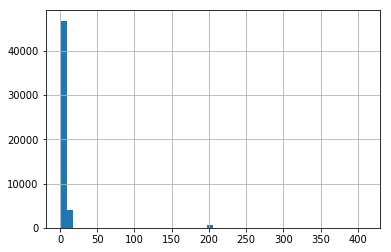